In [1]:
from fastai.vision import *

Lets us look at the 1st type of example with the MNIST example

In [2]:
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False) # here we don't flip the data
path.ls()

[PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/mnist_tiny/train'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/mnist_tiny/labels.csv'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/mnist_tiny/valid'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/mnist_tiny/test'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/mnist_tiny/models')]

In [3]:
(path/'train').ls()

[PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/mnist_tiny/train/7'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/mnist_tiny/train/3')]

In [4]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=64) 

In [5]:
data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

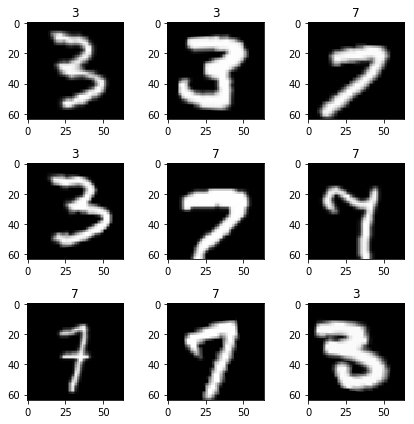

In [11]:

data.show_batch(3, figsize=(6,6), hide_axis=False)

Lets us look at the 2nd type of example from planet data

In [13]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [14]:
pd.read_csv(planet/"labels.csv").head()

,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


In [15]:
data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', label_delim = ' ', ds_tfms=planet_tfms)

With the data block API we can rewrite this like that:

In [17]:
planet.ls()

[PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/planet_tiny/train'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/planet_tiny/labels.csv')]

In [18]:
pd.read_csv(planet/"labels.csv").head()

,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


In [19]:
data = (ImageList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(label_delim=' ')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(planet_tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())                          
        #Finally -> use the defaults for conversion to databunch

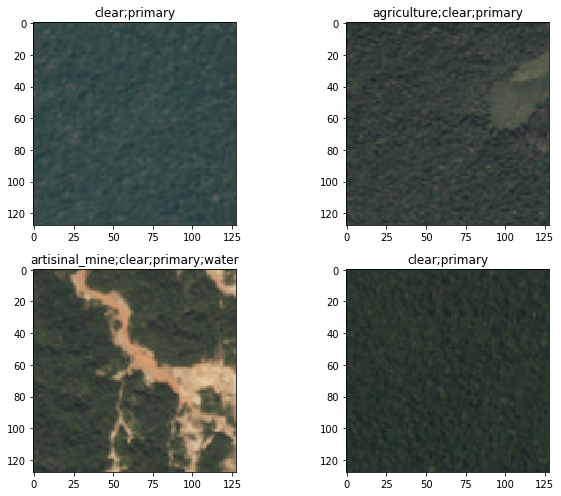

In [25]:
data.show_batch(rows=2, figsize=(9,7),hide_axis=False)

The variant 3 with images

In [26]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

In [27]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [28]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [29]:
data = (SegmentationItemList.from_folder(path_img)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes)
        #How to label? -> use the label function on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=128)
        #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch())
        #Finally -> use the defaults for conversion to databunch

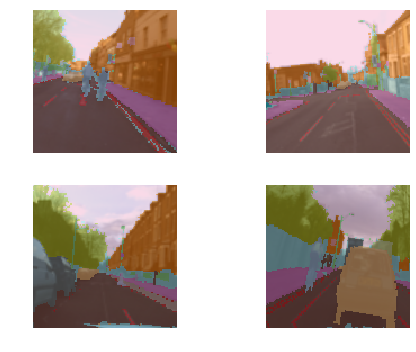

In [33]:
data.show_batch(rows=2, figsize=(7,5), hide_axis=False)

Variant 4 from the coco images

In [34]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [35]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco and its subfolders
        .split_by_rand_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch, use a batch size of 16,
        # and we use bb_pad_collate to collate the data into a mini-batch

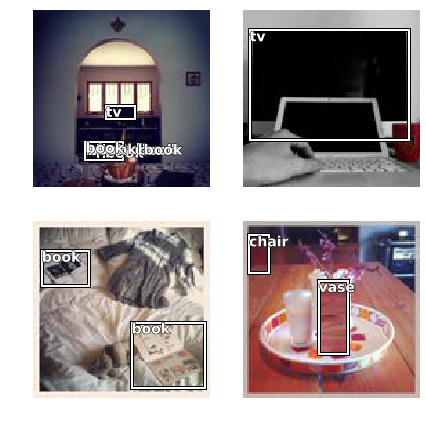

In [36]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(6,6))

Change the blocks to work for IMDB

In [37]:
from fastai.text import *

In [38]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [39]:
data_lm = (TextList
           .from_csv(imdb, 'texts.csv', cols='text')
           #Where are the text? Column 'text' of texts.csv
           .split_by_rand_pct()
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch())
           #Finally we convert to a DataBunch

In [40]:
data_lm.show_batch()

idx,text
0,"! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk ! xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is"
1,"i 'm not opposed to sex in movies , but it should have some point ( unless it 's a xxup xxunk movie ) . xxmaj all in all , we were very disappointed at this xxmaj spike xxmaj lee effort ! ! xxbos a really great movie and true story . xxmaj dan xxmaj jansen the xxmaj greatest xxunk ever . a touching and beautiful movie the whole family"
2,"is well worth seeing . xxbos i caught this on the xxunk last night . i liked the movie . i xxunk to xxmaj russia 3 different times ( xxunk our 2 kids ) . i ca n't put my finger on exactly why i liked this movie other than seeing "" bad "" turn "" good "" and "" good "" turn "" semi - bad "" . i"
3,"it was of a higher quality than other b - xxmaj movies i have seen in the past . \n \n xxmaj the rest of this movie is xxunk bad , xxmaj the camera work often looks like they 've just put the camera man on roller xxunk and pushed him along . xxmaj the story ( if it can be called that ) is so full of holes"
4,"xxmaj on the other hand , xxmaj charles xxmaj xxunk , for all his great acting in other movies , seems to have missed the mark with xxmaj javert . xxmaj the lip xxunk , the unnecessary shouting , and his acting in general all just felt very wrong . xxmaj he also , like many xxmaj xxunk i have seen , did not appear at all menacing , something"


For a classification problem, we just have to change the way labeling is done. Here we use the csv column label.

In [41]:
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text')
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch())

In [42]:
data_clas.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


The variant type of the tabular data

In [43]:
from fastai.tabular import *

In [47]:
adult = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult/'adult.csv')
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_names = ['education-num', 'hours-per-week', 'age', 'capital-loss', 'fnlwgt', 'capital-gain']
procs = [FillMissing, Categorify, Normalize]

In [45]:
data = (TabularList.from_df(df, path=adult, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(800,1000))
                           .label_from_df(cols=dep_var)
                           .databunch())

In [46]:
data.show_batch()

workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,education-num,hours-per-week,age,capital-loss,fnlwgt,capital-gain,target
Private,Some-college,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States,False,-0.0312,1.5843,-0.4828,-0.2164,-0.0846,-0.1459,>=50k
Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,False,-0.4224,-0.0356,-0.2629,-0.2164,-0.0190,-0.1459,<50k
Private,Assoc-voc,Never-married,Other-service,Not-in-family,White,Male,United-States,False,0.3599,-0.0356,-0.1163,-0.2164,-1.5224,-0.1459,<50k
Self-emp-not-inc,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,False,-0.4224,0.7743,1.2030,-0.2164,2.2046,-0.1459,<50k
Private,Some-college,Separated,Adm-clerical,Not-in-family,Black,Male,United-States,False,-0.0312,-0.0356,-0.2629,-0.2164,1.0244,-0.1459,<50k
